In [ ]:
!pip install astunparse keras_preprocessing flatbuffers

In [ ]:
!pip install matplotlib

In [19]:
!pip install mlflow

  Using cached mlflow-1.20.2-py3-none-any.whl (14.6 MB)
  Using cached PyYAML-5.4.1-cp37-cp37m-macosx_10_9_x86_64.whl (249 kB)
  Using cached docker-5.0.2-py2.py3-none-any.whl (145 kB)
  Using cached prometheus_flask_exporter-0.18.2-py3-none-any.whl
  Using cached GitPython-3.1.24-py3-none-any.whl (180 kB)
  Using cached alembic-1.4.1-py2.py3-none-any.whl
  Using cached Flask-2.0.1-py3-none-any.whl (94 kB)
  Using cached sqlparse-0.4.2-py3-none-any.whl (42 kB)
  Using cached SQLAlchemy-1.4.23-cp37-cp37m-macosx_10_14_x86_64.whl (1.5 MB)
  Using cached querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
  Using cached databricks_cli-0.15.0-py3-none-any.whl
  Using cached click-8.0.1-py3-none-any.whl (97 kB)
  Using cached gunicorn-20.1.0-py3-none-any.whl (79 kB)
  Using cached python_editor-1.0.4-py3-none-any.whl (4.9 kB)
  Using cached Mako-1.1.5-py2.py3-none-any.whl (75 kB)
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
  Using cached websocket_client-1.2.1-py2.py3-none-any.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from time import time
import mlflow
mlflow.set_experiment("melusine_tf_probability")

In [4]:
import ast
import pandas as pd
import numpy as np

df_emails_preprocessed = pd.read_csv('tutorial/data/emails_preprocessed.csv', encoding='utf-8', sep=';')
df_emails_preprocessed['clean_header'] = df_emails_preprocessed['clean_header'].astype(str)
df_emails_preprocessed['clean_body'] = df_emails_preprocessed['clean_body'].astype(str)
df_emails_preprocessed['attachment'] = df_emails_preprocessed['attachment'].apply(ast.literal_eval)
df_emails_preprocessed['clean_text'] = df_emails_preprocessed['clean_header'] + " " + df_emails_preprocessed['clean_body']

In [5]:
df_emails_preprocessed.clean_text[0]

'devis habitation je suis client chez vous pouvez vous m etablir un devis pour mon fils qui souhaite louer lappartement suivant : 25 rue du rueimaginaire  flag_cp_ '

In [6]:
df_meta = pd.read_csv('tutorial/data/metadata.csv', encoding='utf-8', sep=';')

In [7]:
X = pd.concat([df_emails_preprocessed['clean_text'],df_meta],axis=1)

In [8]:
from sklearn.preprocessing import LabelEncoder
y = df_emails_preprocessed['label']
le = LabelEncoder()
y = le.fit_transform(y)

In [9]:
from melusine.models.train import NeuralModel

In [10]:
len(np.unique(y))

11

In [11]:
from melusine.nlp_tools.embedding import Embedding

In [12]:
pretrained_embedding = Embedding().load('tutorial/data/embedding.pickle') 

# Deterministic model

In [13]:
from melusine.models.neural_architectures import cnn_model
deterministic_nn_model = NeuralModel(architecture_function=cnn_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=['extension','attachment_type', 'dayofweek', 'hour', 'min'],
                       n_epochs=20)

In [14]:
def fit_log_mlflow(tf_model, **additional_params):
    with mlflow.start_run(run_name="train"):
        t0 = time()
        tf_model.fit(X,y,tensorboard_log_dir="tutorial/data")
        t1 = time() - t0
        accuracy = tf_model.score(X, y)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("time", t1)
        mlflow.log_param("type", tf_model.architecture_function.__name__)
        mlflow.log_param("epochs", tf_model.n_epochs)
        mlflow.log_param("batch_size", tf_model.batch_size)
        mlflow.log_params(additional_params)
    return tf_model

In [15]:
deterministic_model = fit_log_mlflow(deterministic_nn_model, perturbed=False)
    # mlflow.tensorflow.log_model(tf_saved_model_dir, tf_meta_graph_tags, tf_signature_def_key, artifact_path, conda_env=None, signature: mlflow.models.signature.ModelSignature = None, input_example: Union[pandas.core.frame.DataFrame, numpy.ndarray, dict, list] = None, registered_model_name=None, await_registration_for=300, pip_requirements=None, extra_pip_requirements=None)

2021-09-21 17:49:45.743343: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-21 17:49:45.971883: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 17:49:45.971903: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 17:49:45.971983: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-21 17:49:46.041220: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
2/2 [==============================] - 2s 150ms/step - loss: 2.3867 - accuracy: 0.2500
Epoch 2/20
2/2 [==============================] - 0s 44ms/step - loss: 2.2027 - accuracy: 0.3500


2021-09-21 17:49:47.738497: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 17:49:47.738528: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 17:49:47.796017: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-21 17:49:47.804520: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-21 17:49:47.813987: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/data/train/plugins/profile/2021_09_21_17_49_47

2021-09-21 17:49:47.815964: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tutorial/data/train/plugins/profile/2021_09_21_17_49_47/MacBookPro-benoit-FVFXG052HV29.trace.json.gz
2021-09-21 17:49:47.822476: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/data/train/plugins/profile/2021_

Epoch 3/20
2/2 [==============================] - 0s 37ms/step - loss: 2.0262 - accuracy: 0.3250
Epoch 4/20
2/2 [==============================] - 0s 54ms/step - loss: 2.0282 - accuracy: 0.3250
Epoch 5/20
2/2 [==============================] - 0s 74ms/step - loss: 1.9800 - accuracy: 0.3750
Epoch 6/20
2/2 [==============================] - 0s 71ms/step - loss: 1.8555 - accuracy: 0.2750
Epoch 7/20
2/2 [==============================] - 0s 125ms/step - loss: 1.9569 - accuracy: 0.2750
Epoch 8/20
2/2 [==============================] - 0s 46ms/step - loss: 1.8936 - accuracy: 0.3250
Epoch 9/20
2/2 [==============================] - 0s 61ms/step - loss: 1.6863 - accuracy: 0.4000
Epoch 10/20
2/2 [==============================] - 0s 60ms/step - loss: 1.6211 - accuracy: 0.3500
Epoch 11/20
2/2 [==============================] - 0s 44ms/step - loss: 1.4435 - accuracy: 0.5500
Epoch 12/20
2/2 [==============================] - 0s 39ms/step - loss: 1.4569 - accuracy: 0.4500
Epoch 13/20
2/2 [=========

### The deterministic model is able to give us point estimation of probabilities. But we can do better...

In [16]:
deterministic_nn_model.predict_proba(X)[:2]

array([[0.0951639 , 0.05939156, 0.07609528, 0.11999409, 0.12296791,
        0.08800335, 0.07363405, 0.07013807, 0.06950563, 0.07599728,
        0.1491089 ],
       [0.07880303, 0.04688269, 0.06406377, 0.09359903, 0.06688718,
        0.06697895, 0.0632794 , 0.0783072 , 0.07072824, 0.07438176,
        0.29608876]], dtype=float32)

# The probabilitic model 
The probabilitic gives us not longer point estimation but distribution on predictions. It allows us to give confidence intervals.

In [19]:
from melusine.models.probabilistic_neural_architectures import bayesian_cnn_with_meta_model
nn_model = NeuralModel(architecture_function=bayesian_cnn_with_meta_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=['extension','attachment_type', 'dayofweek', 'hour', 'min'],
                       n_epochs=40)

In [20]:
nn_model = fit_log_mlflow(nn_model)

2021-09-21 17:51:02.936718: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-09-21 17:51:02.947619: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 17:51:02.947636: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 17:51:02.947661: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/40
2/2 [==============================] - 2s 264ms/step - loss: 2.3927 - accuracy: 0.1250


2021-09-21 17:51:04.409260: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 17:51:04.409279: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 17:51:04.568709: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-21 17:51:04.572067: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-21 17:51:04.582221: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/data/train/plugins/profile/2021_09_21_17_51_04

2021-09-21 17:51:04.584831: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tutorial/data/train/plugins/profile/2021_09_21_17_51_04/MacBookPro-benoit-FVFXG052HV29.trace.json.gz
2021-09-21 17:51:04.592903: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/data/train/plugins/profile/2021_

Epoch 2/40
2/2 [==============================] - 0s 121ms/step - loss: 2.2531 - accuracy: 0.3250
Epoch 3/40
2/2 [==============================] - 0s 43ms/step - loss: 2.0318 - accuracy: 0.3000
Epoch 4/40
2/2 [==============================] - 0s 47ms/step - loss: 1.8651 - accuracy: 0.3000
Epoch 5/40
2/2 [==============================] - 0s 63ms/step - loss: 2.0610 - accuracy: 0.2500
Epoch 6/40
2/2 [==============================] - 0s 46ms/step - loss: 1.9704 - accuracy: 0.2250
Epoch 7/40
2/2 [==============================] - 0s 39ms/step - loss: 1.6532 - accuracy: 0.4750
Epoch 8/40
2/2 [==============================] - 0s 169ms/step - loss: 1.7658 - accuracy: 0.3500
Epoch 9/40
2/2 [==============================] - 0s 41ms/step - loss: 1.5578 - accuracy: 0.4500
Epoch 10/40
2/2 [==============================] - 0s 56ms/step - loss: 1.4967 - accuracy: 0.5000
Epoch 11/40
2/2 [==============================] - 0s 39ms/step - loss: 1.4627 - accuracy: 0.5250
Epoch 12/40
2/2 [=========

### The estimation of the probability is now the mean of the distribution of the prediction

In [21]:
X_input = nn_model.prepare_email_to_predict(X)
nn_model.model(X_input) # the output of the model is not a vector but a distribution we can sample/compute mean/compute std/...

<tfp.distributions._TensorCoercible 'model_1_one_hot_categorical_tensor_coercible' batch_shape=[40] event_shape=[11] dtype=float32>

In [23]:
better_estimation = nn_model.predict_proba(X)

### More important we now can have confidence intervals

In [24]:
score, inf, sup = nn_model.predict_proba(X, confidence_interval=0.95)

In [25]:
import matplotlib.pyplot as plt
ntargets = 11


def analyse_and_plot_model_predictions(data, true_labels, nn_model, text_num, ci=0.95):
    """
    Make plots of the probabilities that the model estimates for a given text
    """
    true_label = true_labels[text_num]
    true_label_decoded = le.inverse_transform([true_label])[0]
    print('True label: \033[1m \033[92m {} \033[0m'.format(str(true_label_decoded)))
    print('Clean text: ', data.loc[text_num, "clean_text"])
    model_prediction, pct_low, pct_up = nn_model.predict_proba(data.loc[text_num:text_num], confidence_interval=ci)
    model_prediction, pct_low, pct_up = model_prediction[0], pct_low[0], pct_up[0]
    x_pos = np.arange(ntargets)
    bar = plt.bar(x_pos, pct_up, color='red')
    all_categories_decoded = le.inverse_transform(np.arange(ntargets))
    plt.xticks(x_pos, all_categories_decoded, color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
    ax = plt.gca()
    labels = ax.get_xticklabels()
    ticks = ax.get_xticks()
    for label, tick in zip(labels, ticks):
        if tick == true_label:
            label.set_color('green')
    bar[true_label].set_color('green')
    plt.bar(np.arange(ntargets), pct_low-0.02, color='white', linewidth=1, edgecolor='white')
    plt.ylim([0, 1])
    plt.ylabel('Probability')
    plt.title('Model estimated probabilities') 
    plt.show()

True label:   vehicule 
Clean text:  immatriculation voiture je vous informe que la nouvelle immatriculation est enfin faite. je vous prie de trouver donc la carte grise ainsi que la nouvelle immatriculation. je vous demanderai de faire les changements necessaires concernant lassurance.


/Users/benoit/Documents/melusine/melusine/nlp_tools/tokenizer.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["tokens"] = apply_func(X, self.tokenize)
/Users/benoit/Documents/melusine/melusine/nlp_tools/tokenizer.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["tokens"] = apply_func(X, lambda x: x["tokens"][0])


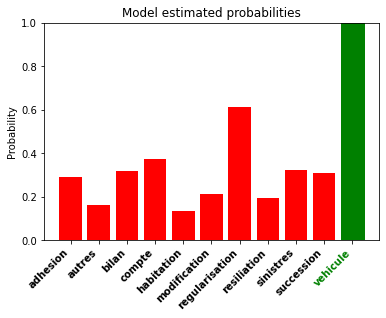

In [26]:
i = 1
analyse_and_plot_model_predictions(X, y, nn_model, text_num=i, ci=0.95)

# To go further : the bayesian neural network

In [33]:
from melusine.models.probabilistic_neural_architectures import variational_cnn_model
variational_nn_model = NeuralModel(architecture_function=variational_cnn_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=[],
                       n_epochs=40)

In [34]:
variational_cnn_model = fit_log_mlflow(variational_nn_model)

/Users/benoit/miniconda3/envs/melusinefork/lib/python3.7/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


2021-09-21 17:57:02.162296: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 17:57:02.162325: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 17:57:02.162385: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/40
2/2 [==============================] - 3s 237ms/step - loss: 7384.4033 - accuracy: 0.1000
Epoch 2/40
2/2 [==============================] - 0s 22ms/step - loss: 7384.0327 - accuracy: 0.0000e+00


2021-09-21 17:57:04.690255: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 17:57:04.690856: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 17:57:04.799361: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-21 17:57:04.802790: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-21 17:57:04.806502: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/data/train/plugins/profile/2021_09_21_17_57_04

2021-09-21 17:57:04.809766: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tutorial/data/train/plugins/profile/2021_09_21_17_57_04/MacBookPro-benoit-FVFXG052HV29.trace.json.gz
2021-09-21 17:57:04.815675: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/data/train/plugins/profile/2021_

Epoch 3/40
2/2 [==============================] - 0s 30ms/step - loss: 7375.5327 - accuracy: 0.0750
Epoch 4/40
2/2 [==============================] - 0s 27ms/step - loss: 7367.2920 - accuracy: 0.1500
Epoch 5/40
2/2 [==============================] - 0s 24ms/step - loss: 7364.4937 - accuracy: 0.0250
Epoch 6/40
2/2 [==============================] - 0s 21ms/step - loss: 7356.1577 - accuracy: 0.0750
Epoch 7/40
2/2 [==============================] - 0s 48ms/step - loss: 7353.1250 - accuracy: 0.2000
Epoch 8/40
2/2 [==============================] - 0s 41ms/step - loss: 7349.9990 - accuracy: 0.0500
Epoch 9/40
2/2 [==============================] - 0s 25ms/step - loss: 7335.4517 - accuracy: 0.0250
Epoch 10/40
2/2 [==============================] - 0s 27ms/step - loss: 7335.7617 - accuracy: 0.0250
Epoch 11/40
2/2 [==============================] - 0s 29ms/step - loss: 7326.6353 - accuracy: 0.2500
Epoch 12/40
2/2 [==============================] - 0s 30ms/step - loss: 7319.5234 - accuracy: 0.27

True label:   vehicule 
Clean text:  pret vehicule ci-joint pret vehicule


/Users/benoit/Documents/melusine/melusine/nlp_tools/tokenizer.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["tokens"] = apply_func(X, self.tokenize)
/Users/benoit/Documents/melusine/melusine/nlp_tools/tokenizer.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["tokens"] = apply_func(X, lambda x: x["tokens"][0])


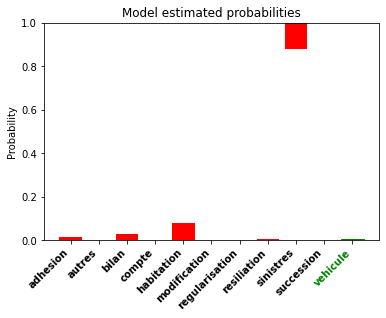

In [36]:
i = 9
analyse_and_plot_model_predictions(X, y, variational_nn_model, i)

In [36]:
from melusine.models.probabilistic_neural_architectures import flipout_cnn_model
flipout_nn_model = NeuralModel(architecture_function=flipout_cnn_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=[],
                       n_epochs=40)

In [37]:
flipout_nn_model = fit_log_mlflow(flipout_nn_model)

/Users/benoit/miniconda3/envs/melusinefork/lib/python3.7/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
2021-09-21 17:59:10.038149: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 17:59:10.038187: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 17:59:10.039483: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/40
2/2 [==============================] - 3s 210ms/step - loss: 7853.0439 - accuracy: 0.1500
Epoch 2/40
1/2 [==============>...............] - ETA: 0s - loss: 7848.1494 - accuracy: 0.1000

2021-09-21 17:59:12.636438: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 17:59:12.636457: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 17:59:12.735078: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-21 17:59:12.739663: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-21 17:59:12.743977: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/data/train/plugins/profile/2021_09_21_17_59_12

2021-09-21 17:59:12.746844: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tutorial/data/train/plugins/profile/2021_09_21_17_59_12/MacBookPro-benoit-FVFXG052HV29.trace.json.gz
2021-09-21 17:59:12.752744: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/data/train/plugins/profile/2021_

2/2 [==============================] - 0s 37ms/step - loss: 7846.5186 - accuracy: 0.1500
Epoch 3/40
2/2 [==============================] - 0s 33ms/step - loss: 7840.0049 - accuracy: 0.1500
Epoch 4/40
2/2 [==============================] - 0s 48ms/step - loss: 7833.5054 - accuracy: 0.1250
Epoch 5/40
2/2 [==============================] - 0s 122ms/step - loss: 7827.0186 - accuracy: 0.1750
Epoch 6/40
2/2 [==============================] - 0s 33ms/step - loss: 7820.5439 - accuracy: 0.2000
Epoch 7/40
2/2 [==============================] - 0s 28ms/step - loss: 7814.0869 - accuracy: 0.1500
Epoch 8/40
2/2 [==============================] - 0s 56ms/step - loss: 7807.6396 - accuracy: 0.2000
Epoch 9/40
2/2 [==============================] - 0s 29ms/step - loss: 7801.2046 - accuracy: 0.2000
Epoch 10/40
2/2 [==============================] - 0s 29ms/step - loss: 7794.7842 - accuracy: 0.1250
Epoch 11/40
2/2 [==============================] - 0s 155ms/step - loss: 7788.3740 - accuracy: 0.2500
Epoch 1

True label:   vehicule 
Clean text:  pret vehicule ci-joint pret vehicule


/Users/benoit/Documents/melusine/melusine/nlp_tools/tokenizer.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["tokens"] = apply_func(X, self.tokenize)
/Users/benoit/Documents/melusine/melusine/nlp_tools/tokenizer.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["tokens"] = apply_func(X, lambda x: x["tokens"][0])


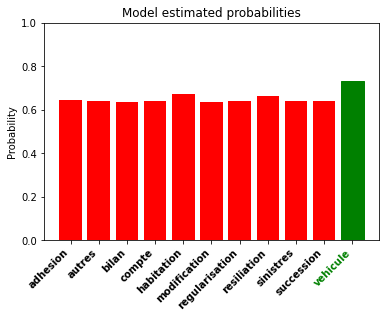

In [38]:
i = 9
analyse_and_plot_model_predictions(X, y, flipout_nn_model, i)

# Analysis

**It would be interesting to identify the emails the model is the most uncertain about.**

Example : 

If you have rush period and transfers are setup between entities to handle peak of emails then you may have errors in the labels. The consequence is the raise of the residual error due to data quality.

## The perturbation in the label is : 
On a defined period, a portion of habitation emails are transfered to adhesion.

We can imagine the `habitation` service had to face a peak of emails at a specific period and transfered an important part of its emails to `adhesion` service

Now the dataset has false labels. A part of the `habitation` emails were indeed transfered to `adhesion` but this is not a behavior we want the model to reproduce.

In [39]:
from melusine.prepare_email.metadata_engineering import MetaDate
meta = MetaDate()
df_emails_preprocessed = meta.transform(df_emails_preprocessed)

In [40]:
import copy
def swap_period(df, origin, destination, start_date, end_date, rate):
    """here we are simulating a period of swap between two services 
    (because of a rush period for instance)
    between the 15 of august and the 1st of september, 
    half of the emails for vehicles are transfered randomly to the other services"""
    
    swapped_df = copy.deepcopy(df)
    is_habitation = swapped_df.eval('label == @origin and date > @start_date and date < @end_date')
    idx_habitation = is_habitation.index[is_habitation]

    n_habitation = len(idx_habitation)
    num_to_transfer = int(rate*n_habitation)
    idx_to_transfer = np.random.choice(idx_habitation, replace=False, size=num_to_transfer)
    swapped_df.loc[:,"swapped_label"] = swapped_df.loc[:,"label"]
    swapped_df.loc[idx_to_transfer,"swapped_label"] = destination
    return swapped_df

In [41]:
np.random.seed(1347)
perturbed_df = swap_period(df_emails_preprocessed, "habitation", "adhesion", "2017-06-05 00:00:00", "2018-06-07 00:00:00", 0.5)

In [42]:
swapped_emails = perturbed_df.query("label != swapped_label")
print(swapped_emails.filter(["clean_text", "label", "swapped_label"]))

                                           clean_text       label  \
14  correspondance de la societe imaginaire bonjou...  habitation   
22  reclamations numero tel. :  flag_phone_  e-mai...  habitation   
33  declarations de sinistre corporel et materiel ...  habitation   

   swapped_label  
14      adhesion  
22      adhesion  
33      adhesion  


## Let's train a model on this perturbed data

In [43]:
from sklearn.preprocessing import LabelEncoder
perturbed_y = perturbed_df['swapped_label']
le = LabelEncoder()
perturbed_y = le.fit_transform(perturbed_y)

In [44]:
from melusine.models.neural_architectures import cnn_model
perturbed_nn_model = NeuralModel(architecture_function=cnn_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=['extension','attachment_type', 'dayofweek', 'hour', 'min'],
                       n_epochs=40)

In [45]:
perturbed_nn_model = fit_log_mlflow(perturbed_nn_model, perturbed=True)

2021-09-21 17:59:41.834672: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 17:59:41.834691: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 17:59:41.834713: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/40
2/2 [==============================] - 2s 231ms/step - loss: 2.3685 - accuracy: 0.2250


2021-09-21 17:59:43.314382: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 17:59:43.314405: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 17:59:43.457818: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-21 17:59:43.461683: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-21 17:59:43.465050: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/data/train/plugins/profile/2021_09_21_17_59_43

2021-09-21 17:59:43.467913: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tutorial/data/train/plugins/profile/2021_09_21_17_59_43/MacBookPro-benoit-FVFXG052HV29.trace.json.gz
2021-09-21 17:59:43.478011: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/data/train/plugins/profile/2021_

Epoch 2/40
2/2 [==============================] - 0s 86ms/step - loss: 2.2020 - accuracy: 0.3500
Epoch 3/40
2/2 [==============================] - 0s 35ms/step - loss: 2.0494 - accuracy: 0.3250
Epoch 4/40
2/2 [==============================] - 0s 67ms/step - loss: 2.0506 - accuracy: 0.3250
Epoch 5/40
2/2 [==============================] - 0s 185ms/step - loss: 1.9643 - accuracy: 0.3750
Epoch 6/40
2/2 [==============================] - 0s 34ms/step - loss: 1.8380 - accuracy: 0.4250
Epoch 7/40
2/2 [==============================] - 0s 48ms/step - loss: 1.7102 - accuracy: 0.5000
Epoch 8/40
2/2 [==============================] - 0s 153ms/step - loss: 1.7958 - accuracy: 0.4250
Epoch 9/40
2/2 [==============================] - 0s 41ms/step - loss: 1.6525 - accuracy: 0.3250
Epoch 10/40
2/2 [==============================] - 0s 46ms/step - loss: 1.6549 - accuracy: 0.4000
Epoch 11/40
2/2 [==============================] - 0s 163ms/step - loss: 1.5238 - accuracy: 0.5500
Epoch 12/40
2/2 [========

the date features are `dayofweek`, `hour`, `min` but no `month` nor `dayofyear` 

so for an email that appear during the period of swap, we would like the model to predict `habitation` (the **true** label)

In [46]:
swapped_X = X.loc[swapped_emails.index]
predict_swapped = perturbed_nn_model.predict(swapped_X)
predicted_label_swapped = le.inverse_transform(predict_swapped)
print(predicted_label_swapped)

['vehicule' 'vehicule' 'vehicule']


a robust model should have predicted `habitation`

Now look at the `habitation` emails that were not swapped.

In [48]:
habitation_not_swapped = perturbed_df.query('label == swapped_label and label == "habitation"')
habitation_not_swapped_features = X.loc[habitation_not_swapped.index]
predict_habitation_not_swapped = perturbed_nn_model.predict(X.loc[habitation_not_swapped.index])
predict_label_habitation_not_swapped = le.inverse_transform(predict_habitation_not_swapped)
print(predict_label_habitation_not_swapped)

['vehicule' 'habitation' 'bilan' 'vehicule' 'habitation']


the model is confused about the all `habitation` emails and not only with emails that were swapped

In [50]:
perturbed_bayesian_cnn_model = NeuralModel(architecture_function=bayesian_cnn_with_meta_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=['extension','attachment_type', 'dayofweek', 'hour', 'min'],
                       n_epochs=40)

In [51]:
perturbed_bayesian_cnn_model = fit_log_mlflow(perturbed_bayesian_cnn_model, perturbed=True)

2021-09-21 18:01:50.833590: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 18:01:50.833625: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-21 18:01:50.833851: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/40
2/2 [==============================] - ETA: 0s - loss: 2.3672 - accuracy: 0.1750

2021-09-21 18:01:52.675399: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-21 18:01:52.677074: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


2/2 [==============================] - 2s 613ms/step - loss: 2.3672 - accuracy: 0.1750


2021-09-21 18:01:53.014832: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-21 18:01:53.030037: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-21 18:01:53.035359: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/data/train/plugins/profile/2021_09_21_18_01_53

2021-09-21 18:01:53.052363: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tutorial/data/train/plugins/profile/2021_09_21_18_01_53/MacBookPro-benoit-FVFXG052HV29.trace.json.gz
2021-09-21 18:01:53.105568: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/data/train/plugins/profile/2021_09_21_18_01_53

2021-09-21 18:01:53.145471: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to tutorial/data/train/plugins/profile/2021_09_21_18_01_53/MacBookPro-

Epoch 2/40
2/2 [==============================] - 0s 50ms/step - loss: 2.2289 - accuracy: 0.3500
Epoch 3/40
2/2 [==============================] - 0s 46ms/step - loss: 2.0561 - accuracy: 0.2750
Epoch 4/40
2/2 [==============================] - 0s 178ms/step - loss: 2.1226 - accuracy: 0.3250
Epoch 5/40
2/2 [==============================] - 0s 87ms/step - loss: 1.8650 - accuracy: 0.3750
Epoch 6/40
2/2 [==============================] - 0s 81ms/step - loss: 1.8525 - accuracy: 0.2750
Epoch 7/40
2/2 [==============================] - 0s 69ms/step - loss: 1.8011 - accuracy: 0.4000
Epoch 8/40
2/2 [==============================] - 0s 74ms/step - loss: 1.6892 - accuracy: 0.4500
Epoch 9/40
2/2 [==============================] - 0s 56ms/step - loss: 1.6201 - accuracy: 0.4000
Epoch 10/40
2/2 [==============================] - 0s 81ms/step - loss: 1.6165 - accuracy: 0.3500
Epoch 11/40
2/2 [==============================] - 0s 55ms/step - loss: 1.3471 - accuracy: 0.5250
Epoch 12/40
2/2 [==========

In [52]:
swapped_X = X.loc[swapped_emails.index]
predict_swapped = perturbed_bayesian_cnn_model.predict(swapped_X)
predicted_label_swapped = le.inverse_transform(predict_swapped)
print(predicted_label_swapped)

['vehicule' 'vehicule' 'vehicule']


True label:   habitation 
Clean text:  correspondance de la societe imaginaire bonjour, merci de votre retour rapide. concernent l'attestation du 22 septembre, serait-il possible de faire apparaitre l'adresse complete de l'evenement. en effet, s'agissant d'un domaine prive, les proprietaires nous ont fait cette demande.


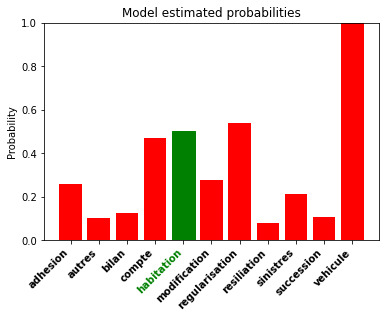

In [54]:
idx_swapped = swapped_emails.index[0]
analyse_and_plot_model_predictions(X, y, perturbed_bayesian_cnn_model, idx_swapped)

True label:   habitation 
Clean text:  changement d'adresse permettez-moi de vous signaler un changement d'adresse me concernant. voici ma nouvelle adresse : 00 rue du nomderue  flag_cp_  paris


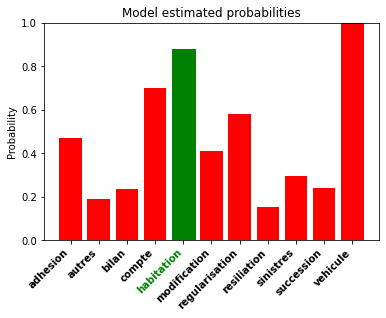

In [55]:
idx_habi_not_swapped = habitation_not_swapped.index[2]
analyse_and_plot_model_predictions(X, y, perturbed_bayesian_cnn_model, idx_habi_not_swapped)

# TODO : define a condition to identify the email we need to check again
Example : 

The emails where the top level of confidence is low
The emails where the bottom level of confidence is low
The emails where the mean of the score is low
The email with the label : `adhesion` where the confidence of `habitation` is high

## Usecase : What if a mail has several categories ?

Let's concatenate 2 mails of differents categories

In [31]:
i=4
true_label_decoded = le.inverse_transform([y[i]])[0]
print('True label: \033[1m \033[92m {} \033[0m'.format(str(true_label_decoded)))
print(X.loc[i,"clean_text"])

True label:   adhesion 
bulletin de salaire voici ci joint mon bulletin de salaire comme demande.


In [32]:
i=5
true_label_decoded = le.inverse_transform([y[i]])[0]
print('True label: \033[1m \033[92m {} \033[0m'.format(str(true_label_decoded)))
print(X.loc[i,"clean_text"])

True label:   habitation 
modification et extension de ma maison je vous avais contactes car j'avais pour projet d'agrandir ma maison. j'avais recu un devis pour lequel je n'avais pas donne suite, les travaux n'etant pas encore realises. le projet a maintenant ete porte a son terme et je voudrais donc revoir votre offre si possible. je desire garder le meme type de contrat.


In [33]:
def fusion_rows(df, indice_1, indice_2):
    row_1 = df.loc[indice_1]
    row_2 = df.loc[indice_2]
    dict_agg = {}

    for colname in df.columns:
        if colname.startswith(('attachment_type', 'extension__', 'tokens')):
            # sum of the values (attachments, extension) and concat the lists of tokens
            agg_value = np.sum([row_1[colname], row_2[colname]])
        elif colname == "clean_text":
            # we concatenate with a dot as a separator
            agg_value = ". ".join([row_1[colname], row_2[colname]])
        else:
            # we retain the value of the first email
            agg_value = row_2[colname]
        dict_agg[colname] = agg_value
    row_agg = pd.Series(dict_agg)
    df_agg = pd.DataFrame([row_agg])
    return df_agg
merged = fusion_rows(X, 4, 5)

/Users/benoit/miniconda3/envs/melusinefork/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [34]:
merged["clean_text"].loc[0]

"bulletin de salaire voici ci joint mon bulletin de salaire comme demande.. modification et extension de ma maison je vous avais contactes car j'avais pour projet d'agrandir ma maison. j'avais recu un devis pour lequel je n'avais pas donne suite, les travaux n'etant pas encore realises. le projet a maintenant ete porte a son terme et je voudrais donc revoir votre offre si possible. je desire garder le meme type de contrat."

True label:   adhesion 
Clean text:  bulletin de salaire voici ci joint mon bulletin de salaire comme demande.. modification et extension de ma maison je vous avais contactes car j'avais pour projet d'agrandir ma maison. j'avais recu un devis pour lequel je n'avais pas donne suite, les travaux n'etant pas encore realises. le projet a maintenant ete porte a son terme et je voudrais donc revoir votre offre si possible. je desire garder le meme type de contrat.


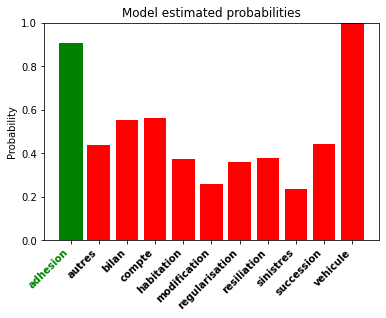

In [35]:
analyse_and_plot_model_predictions(merged, [y[4]], nn_model, 0)

True label:   adhesion 
Clean text:  bulletin de salaire voici ci joint mon bulletin de salaire comme demande.. modification et extension de ma maison je vous avais contactes car j'avais pour projet d'agrandir ma maison. j'avais recu un devis pour lequel je n'avais pas donne suite, les travaux n'etant pas encore realises. le projet a maintenant ete porte a son terme et je voudrais donc revoir votre offre si possible. je desire garder le meme type de contrat.


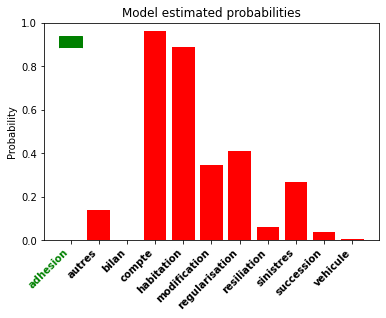

In [36]:
analyse_and_plot_model_predictions(merged, [y[4]], variational_nn_model, 0)

True label:   adhesion 
Clean text:  bulletin de salaire voici ci joint mon bulletin de salaire comme demande.. modification et extension de ma maison je vous avais contactes car j'avais pour projet d'agrandir ma maison. j'avais recu un devis pour lequel je n'avais pas donne suite, les travaux n'etant pas encore realises. le projet a maintenant ete porte a son terme et je voudrais donc revoir votre offre si possible. je desire garder le meme type de contrat.


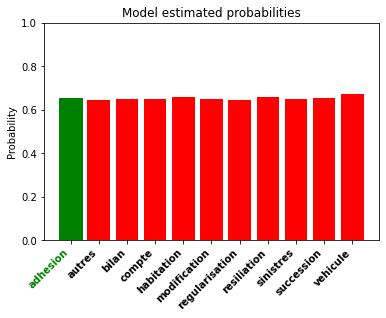

In [37]:
analyse_and_plot_model_predictions(merged, [y[4]], flipout_nn_model, 0)

In [ ]:
epistemic : sur des data qui ont peu été vues.
aleatoric : l'erreur du à la labellisation

In [74]:
y

array([ 4, 10,  3,  0,  0,  4,  7, 10,  1, 10,  2,  5, 10, 10,  4,  7,  7,
       10,  0,  9,  4, 10,  4,  7, 10, 10,  6,  7,  3,  8, 10, 10, 10,  4,
        7,  3,  5,  4,  4, 10])

In [86]:
from tensorflow_probability import distributions as tfd
features = tfd.Normal(loc=0., scale=1.).sample(int(5))
bernoulli = tfd.Bernoulli(logits=1.618 * features)

In [87]:
bernoulli.mean()

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.8882861 , 0.9331638 , 0.95070904, 0.15552284, 0.2400191 ],
      dtype=float32)>

In [93]:
bernoulli.cdf(0.1)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.11171389, 0.06683618, 0.04929096, 0.8444772 , 0.7599809 ],
      dtype=float32)>

In [92]:
bernoulli.cdf(0.95)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.11171389, 0.06683618, 0.04929096, 0.8444772 , 0.7599809 ],
      dtype=float32)>

In [91]:
bernoulli.cdf(0.5)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.11171389, 0.06683618, 0.04929096, 0.8444772 , 0.7599809 ],
      dtype=float32)>

In [94]:
bernoulli.prob(0.05)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.1239166 , 0.07625338, 0.05715193, 0.77597594, 0.71742225],
      dtype=float32)>

In [100]:
bernoulli.cdf?

Signature: bernoulli.cdf(value, name='cdf', **kwargs)
Docstring:
Cumulative distribution function.

Given random variable `X`, the cumulative distribution function `cdf` is:

```none
cdf(x) := P[X <= x]
```

Args:
  value: `float` or `double` `Tensor`.
  name: Python `str` prepended to names of ops created by this function.
  **kwargs: Named arguments forwarded to subclass implementation.

Returns:
  cdf: a `Tensor` of shape `sample_shape(x) + self.batch_shape` with
    values of type `self.dtype`.
File:      /opt/conda/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py
Type:      method


In [99]:
bernoulli.quantile?

Signature: bernoulli.quantile(value, name='quantile', **kwargs)
Docstring:
Quantile function. Aka 'inverse cdf' or 'percent point function'.

Given random variable `X` and `p in [0, 1]`, the `quantile` is:

```none
quantile(p) := x such that P[X <= x] == p
```

Args:
  value: `float` or `double` `Tensor`.
  name: Python `str` prepended to names of ops created by this function.
  **kwargs: Named arguments forwarded to subclass implementation.

Returns:
  quantile: a `Tensor` of shape `sample_shape(x) + self.batch_shape` with
    values of type `self.dtype`.
File:      /opt/conda/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py
Type:      method


In [80]:
bernoulli.prob?

Signature: bernoulli.prob(value, name='prob', **kwargs)
Docstring:
Probability density/mass function.

Args:
  value: `float` or `double` `Tensor`.
  name: Python `str` prepended to names of ops created by this function.
  **kwargs: Named arguments forwarded to subclass implementation.

Returns:
  prob: a `Tensor` of shape `sample_shape(x) + self.batch_shape` with
    values of type `self.dtype`.
File:      /opt/conda/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py
Type:      method


In [78]:
bernoulli.prob(0.95)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.14039457, 0.19465165, 0.25647277, 0.3696385 , 0.36143744],
      dtype=float32)>

In [68]:
features = tfd.Normal(loc=0., scale=1.).sample(int(5))
bernoulli = tfd.Bernoulli(logits=1.618 * features)
print("bernoulli.cdf(0.95)", bernoulli.cdf(0.95))
bernoulli.cdf?

bernoulli.cdf(0.95) tf.Tensor([0.87247586 0.81953216 0.7577414  0.6409152  0.6495433 ], shape=(5,), dtype=float32)


Signature: bernoulli.cdf(value, name='cdf', **kwargs)
Docstring:
Cumulative distribution function.

Given random variable `X`, the cumulative distribution function `cdf` is:

```none
cdf(x) := P[X <= x]
```

Args:
  value: `float` or `double` `Tensor`.
  name: Python `str` prepended to names of ops created by this function.
  **kwargs: Named arguments forwarded to subclass implementation.

Returns:
  cdf: a `Tensor` of shape `sample_shape(x) + self.batch_shape` with
    values of type `self.dtype`.
File:      /opt/conda/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py
Type:      method


<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.43110496, 0.5567271 , 0.88557   , 0.05961686, 0.96272886,
       0.3849101 , 0.84136146, 0.03067887, 0.8896462 , 0.20625603,
       0.24786615, 0.60711765, 0.3435384 , 0.28218108, 0.10468102,
       0.8444642 , 0.01992315, 0.22752297, 0.77935624, 0.24141413,
       0.8758018 , 0.723384  , 0.23492748, 0.36119676, 0.7137803 ,
       0.07756138, 0.5637373 , 0.7721677 , 0.88487196, 0.39660627,
       0.5715605 , 0.7153101 , 0.70246327, 0.8458277 , 0.5728475 ,
       0.5862157 , 0.65055484, 0.9102088 , 0.33827293, 0.08946258,
       0.26819146, 0.09365308, 0.08825713, 0.9648313 , 0.58598834,
       0.74852586, 0.04141301, 0.3953362 , 0.6056563 , 0.9789175 ,
       0.49299073, 0.34908152, 0.15568525, 0.16918254, 0.46534127,
       0.07172453, 0.40860653, 0.26030278, 0.35145527, 0.5460242 ,
       0.4769727 , 0.5961213 , 0.39661366, 0.61699116, 0.6963072 ,
       0.5307225 , 0.03820926, 0.71333754, 0.46681446, 0.23030603,
       0.26619

In [ ]:
tfd.Bernoulli(logits=1.618 * features).cdf

In [ ]:
tfd.Bernoulli(logits=1.618 * features).cdf

In [53]:
labels.cdf?

Signature: labels.cdf(value, name='cdf', **kwargs)
Docstring:
Cumulative distribution function.

Given random variable `X`, the cumulative distribution function `cdf` is:

```none
cdf(x) := P[X <= x]
```

Args:
  value: `float` or `double` `Tensor`.
  name: Python `str` prepended to names of ops created by this function.
  **kwargs: Named arguments forwarded to subclass implementation.

Returns:
  cdf: a `Tensor` of shape `sample_shape(x) + self.batch_shape` with
    values of type `self.dtype`.
File:      /opt/conda/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py
Type:      method


In [42]:
labels.__dir__()

['_parameters',
 '_probs',
 '_logits',
 '_name',
 '_name_scope',
 '_dtype',
 '_reparameterization_type',
 '_allow_nan_stats',
 '_validate_args',
 '_parameters_sanitized',
 '_self_setattr_tracking',
 '_self_unconditional_checkpoint_dependencies',
 '_self_unconditional_dependency_names',
 '_self_unconditional_deferred_dependencies',
 '_self_update_uid',
 '_self_name_based_restores',
 '_self_saveable_object_factories',
 '_graph_parents',
 '_defer_all_assertions',
 '_initial_parameter_control_dependencies',
 '_Distribution__cached_batch_shape',
 '__module__',
 '__doc__',
 '__init__',
 '_parameter_properties',
 'logits',
 'probs',
 '_event_shape_tensor',
 '_event_shape',
 '_sample_n',
 '_log_prob',
 '_outcome_log_probs',
 '_cdf',
 '_entropy',
 '_mean',
 '_variance',
 '_mode',
 'logits_parameter',
 '_logits_parameter_no_checks',
 'probs_parameter',
 '_probs_parameter_no_checks',
 '_default_event_space_bijector',
 '_parameter_control_dependencies',
 '_sample_control_dependencies',
 'cross_ent

In [105]:
X_input = nn_model.prepare_email_to_predict(X)
nn_model.model(X_input)

<tfp.distributions.OneHotCategorical 'model_one_hot_categorical_OneHotCategorical_OneHotCategorical' batch_shape=[40] event_shape=[11] dtype=float32>

In [108]:
nn_model.model(X_input).prob(0.5)

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([4.52391596e-12, 1.81985340e-13, 1.07441206e-15, 9.66536712e-11,
       2.03147943e-09, 6.21834528e-10, 3.88106214e-09, 2.56384269e-19,
       2.84721313e-08, 2.50929665e-14, 2.54012904e-11, 5.91992318e-07,
       3.27808744e-29, 7.57826148e-15, 3.34826680e-11, 2.24422947e-09,
       1.22682486e-08, 2.38922898e-17, 2.11296604e-15, 6.83143776e-12,
       8.53359883e-10, 1.00269220e-24, 2.46352526e-13, 2.92819796e-10,
       4.23993590e-14, 1.47480293e-20, 3.42559581e-08, 2.31843540e-08,
       7.61404777e-15, 5.46089666e-07, 4.07053762e-21, 1.02651084e-14,
       1.00367065e-19, 1.88005629e-08, 3.99538962e-08, 1.73913348e-22,
       2.86172259e-08, 4.49943238e-09, 8.31410808e-12, 4.58630572e-23],
      dtype=float32)>

In [109]:
nn_model.model(X_input).prob(0.95)

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([2.78918522e-22, 6.22402873e-25, 3.62430675e-29, 9.37377937e-20,
       3.05381947e-17, 3.22094949e-18, 1.04473335e-16, 4.75219169e-36,
       4.60678689e-15, 1.44261459e-26, 7.39989314e-21, 1.47028147e-12,
       0.00000000e+00, 1.48314189e-27, 1.25071348e-20, 3.69000838e-17,
       9.30436364e-16, 2.62235363e-32, 1.31008134e-28, 6.10342212e-22,
       5.87696440e-18, 0.00000000e+00, 1.10651409e-24, 7.70090520e-19,
       3.90826098e-26, 2.09213623e-38, 6.54634072e-15, 3.11795242e-15,
       1.49646885e-27, 1.26125434e-12, 0.00000000e+00, 2.63991455e-27,
       7.99880804e-37, 2.09374940e-15, 8.76926688e-15, 0.00000000e+00,
       4.65149879e-15, 1.38356638e-16, 8.86441762e-22, 0.00000000e+00],
      dtype=float32)>

In [121]:
onehotcat = nn_model.model(X_input)
onehotcat.cdf?

Signature: onehotcat.cdf(value, name='cdf', **kwargs)
Docstring:
Cumulative distribution function.

Given random variable `X`, the cumulative distribution function `cdf` is:

```none
cdf(x) := P[X <= x]
```

Args:
  value: `float` or `double` `Tensor`.
  name: Python `str` prepended to names of ops created by this function.
  **kwargs: Named arguments forwarded to subclass implementation.

Returns:
  cdf: a `Tensor` of shape `sample_shape(x) + self.batch_shape` with
    values of type `self.dtype`.
File:      /opt/conda/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py
Type:      method


In [ ]:
onehotcat = nn_model.model(X_input).prob

In [119]:
nn_model.model(X_input).prob(0.5)

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([4.52391596e-12, 1.81985340e-13, 1.07441206e-15, 9.66536712e-11,
       2.03147943e-09, 6.21834528e-10, 3.88106214e-09, 2.56384269e-19,
       2.84721313e-08, 2.50929665e-14, 2.54012904e-11, 5.91992318e-07,
       3.27808744e-29, 7.57826148e-15, 3.34826680e-11, 2.24422947e-09,
       1.22682486e-08, 2.38922898e-17, 2.11296604e-15, 6.83143776e-12,
       8.53359883e-10, 1.00269220e-24, 2.46352526e-13, 2.92819796e-10,
       4.23993590e-14, 1.47480293e-20, 3.42559581e-08, 2.31843540e-08,
       7.61404777e-15, 5.46089666e-07, 4.07053762e-21, 1.02651084e-14,
       1.00367065e-19, 1.88005629e-08, 3.99538962e-08, 1.73913348e-22,
       2.86172259e-08, 4.49943238e-09, 8.31410808e-12, 4.58630572e-23],
      dtype=float32)>

In [120]:
nn_model.model(X_input).prob(0.51)

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([2.68303240e-12, 1.01213234e-13, 5.39255850e-16, 6.09428966e-11,
       1.36134704e-09, 4.06958217e-10, 2.63469224e-09, 1.08910012e-19,
       2.01145056e-08, 1.34135299e-14, 1.55938300e-11, 4.44387979e-07,
       8.82945141e-30, 3.95513734e-15, 2.06688347e-11, 1.50691404e-09,
       8.52231530e-09, 1.11128109e-17, 1.07495321e-15, 4.08509294e-12,
       5.62023927e-10, 3.32043215e-25, 1.37844014e-13, 1.88770055e-10,
       2.29036896e-14, 5.91708667e-21, 2.42902285e-08, 1.63116702e-08,
       3.97417822e-15, 4.09270314e-07, 1.59163929e-21, 5.39001115e-15,
       4.18432059e-20, 1.31721052e-08, 2.84178228e-08, 6.38472399e-23,
       2.02190513e-08, 3.06352188e-09, 4.99128907e-12, 1.63942635e-23],
      dtype=float32)>

In [123]:
nn_model.model(X_input).quantile(0.9)

NotImplementedError: quantile is not implemented: OneHotCategorical

In [124]:
dir(nn_model.model(X_input))

['_TF_MODULE_IGNORED_PROPERTIES',
 '__abs__',
 '__abstractmethods__',
 '__add__',
 '__and__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__iter__',
 '__le__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_allow_nan_stats',
 '_batch_shape',
 '_batch_shape_tensor',

In [136]:
nn_model.model(X_input).prob(0.5)

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([4.52391596e-12, 1.81985340e-13, 1.07441206e-15, 9.66536712e-11,
       2.03147943e-09, 6.21834528e-10, 3.88106214e-09, 2.56384269e-19,
       2.84721313e-08, 2.50929665e-14, 2.54012904e-11, 5.91992318e-07,
       3.27808744e-29, 7.57826148e-15, 3.34826680e-11, 2.24422947e-09,
       1.22682486e-08, 2.38922898e-17, 2.11296604e-15, 6.83143776e-12,
       8.53359883e-10, 1.00269220e-24, 2.46352526e-13, 2.92819796e-10,
       4.23993590e-14, 1.47480293e-20, 3.42559581e-08, 2.31843540e-08,
       7.61404777e-15, 5.46089666e-07, 4.07053762e-21, 1.02651084e-14,
       1.00367065e-19, 1.88005629e-08, 3.99538962e-08, 1.73913348e-22,
       2.86172259e-08, 4.49943238e-09, 8.31410808e-12, 4.58630572e-23],
      dtype=float32)>

In [138]:
nn_model.model(X_input).variance

<bound method Distribution.variance of <tfp.distributions.OneHotCategorical 'model_one_hot_categorical_OneHotCategorical_OneHotCategorical' batch_shape=[40] event_shape=[11] dtype=float32>>

In [128]:
nn_model.model(X_input).covariance()

<tf.Tensor: shape=(40, 11, 11), dtype=float32, numpy=
array([[[ 3.89816146e-03, -1.17768313e-05, -3.67349385e-05, ...,
         -1.19004517e-05, -1.56177921e-05, -1.76165358e-03],
        [-1.17768313e-05,  3.00024566e-03, -2.82476485e-05, ...,
         -9.15095552e-06, -1.20094355e-05, -1.35463872e-03],
        [-3.67349385e-05, -2.82476485e-05,  9.29866731e-03, ...,
         -2.85441620e-05, -3.74604897e-05, -4.22546314e-03],
        ...,
        [-1.19004517e-05, -9.15095552e-06, -2.85441620e-05, ...,
          3.03164287e-03, -1.21354979e-05, -1.36885815e-03],
        [-1.56177921e-05, -1.20094355e-05, -3.74604897e-05, ...,
         -1.21354979e-05,  3.97484563e-03, -1.79644790e-03],
        [-1.76165358e-03, -1.35463872e-03, -4.22546314e-03, ...,
         -1.36885815e-03, -1.79644790e-03,  2.47515038e-01]],

       [[ 2.99727097e-02, -4.81291718e-05, -4.52161075e-05, ...,
         -2.34159979e-05, -3.91967740e-04, -2.79702414e-02],
        [-4.81291718e-05,  1.55367982e-03, -2.274

In [140]:
from tensorflow_probability import layers as tfpl
tfpl.OneHotCategorical.params_size(ntargets)

11